Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [6]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import zipfile
import pathlib

# Define the path to the zip file
file_path = "/content/drive/My Drive/ColabNotebooks/CNN_assignment.zip"


# Define the extraction directory
extract_to = "/content/CNN_assignment"

In [8]:
# Unzip the file
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [9]:
import os
print(os.listdir(extract_to))


['Skin cancer ISIC The International Skin Imaging Collaboration']


In [10]:
# Define the base directory of extracted files
base_dir = pathlib.Path(extract_to) / "Skin cancer ISIC The International Skin Imaging Collaboration"

# Define train and test directories
data_dir_train = base_dir / "Train"
data_dir_test = base_dir / "Test"

# Print paths to verify
print(f"Train Directory: {data_dir_train}")
print(f"Test Directory: {data_dir_test}")

# Verify that the train and test folders exist
print("Contents of base directory:", os.listdir(base_dir))


Train Directory: /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train
Test Directory: /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test
Contents of base directory: ['Test', 'Train']


In [11]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [12]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [13]:
# Load the training dataset (80% of data)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,  # 20% for validation
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [14]:
# Load the validation dataset (20% of data)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,  # Use same directory
    validation_split=0.2,  # 20% for validation
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [15]:
# Print class names to verify
class_names = train_ds.class_names
print("Class Names:", class_names)

Class Names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data
Todo, create a code to visualize one instance of all the nine classes present in the dataset

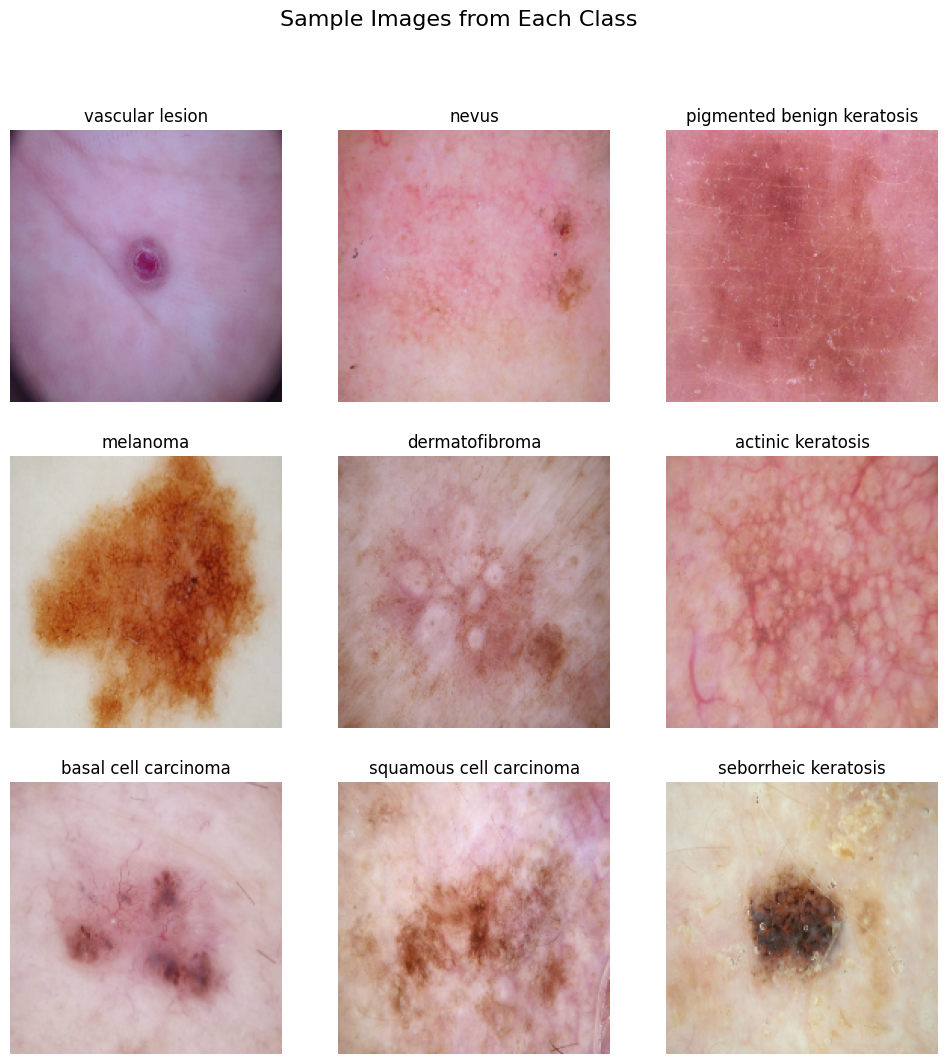

In [16]:
import matplotlib.pyplot as plt

# Get class names
class_names = train_ds.class_names

# Create a dictionary to store one image per class
class_images = {}

# Iterate through the dataset and store one image per class
for images, labels in train_ds:
    for img, label in zip(images, labels.numpy()):
        class_name = class_names[label]
        if class_name not in class_images:
            class_images[class_name] = img  # Store the first occurrence
        if len(class_images) == 9:  # Stop once we have all 9 classes
            break
    if len(class_images) == 9:
        break

# Plot images of each class
plt.figure(figsize=(12, 12))
for i, (class_name, img) in enumerate(class_images.items()):
    plt.subplot(3, 3, i + 1)  # Create a 3x3 grid
    plt.imshow(img.numpy().astype("uint8"))  # Convert tensor to NumPy image
    plt.title(class_name)  # Set title as class name
    plt.axis("off")  # Hide axis

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.show()


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [18]:
# Define image size and number of classes
num_classes = 9

# Build CNN model (No Dropout)
model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixels

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Since labels are integers
              metrics=['accuracy'])

In [20]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.2360 - loss: 2.0858 - val_accuracy: 0.3087 - val_loss: 1.8459
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3787 - loss: 1.6539 - val_accuracy: 0.4720 - val_loss: 1.4991
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4746 - loss: 1.4658 - val_accuracy: 0.4631 - val_loss: 1.5025
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5166 - loss: 1.3658 - val_accuracy: 0.3714 - val_loss: 1.9069
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5134 - loss: 1.4526 - val_accuracy: 0.5213 - val_loss: 1.4015
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5941 - loss: 1.1202 - val_accuracy: 0.5347 - val_loss: 1.4574
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6408 - loss: 1.0704 - val_accuracy: 0.5548 - val_loss: 1.3610
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.6538 - loss: 0.9990 - val_accuracy: 0.5615 -

### Visualizing training results

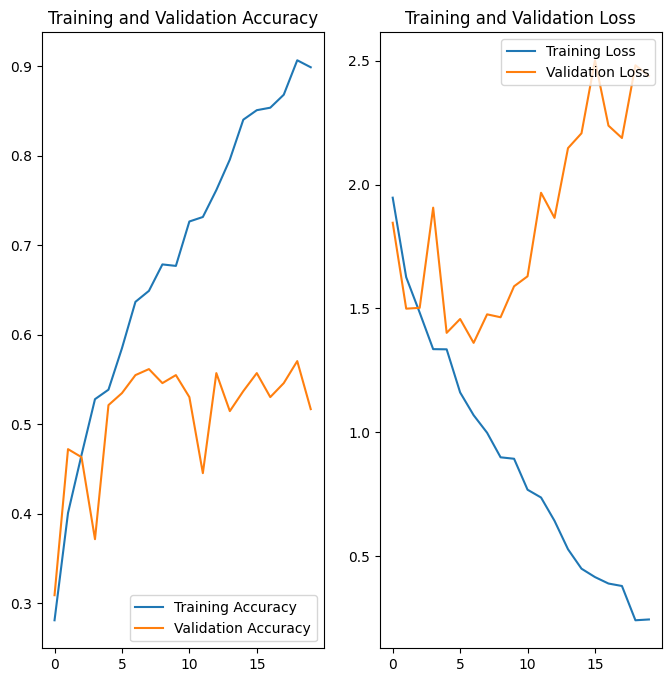

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training Accuracy vs. Validation Accuracy

Training Accuracy (Epoch 20): 92.06%
Validation Accuracy (Epoch 20): 51.68%
The model learns well on training data but performs poorly on validation data, indicating overfitting. It memorizes training data but fails to generalize.
Training Loss vs. Validation Loss

Training Loss (Epoch 20): 0.1958 (very low)
Validation Loss (Epoch 20): 2.4387 (very high)
Decreasing training loss shows improvement on training data. However, increasing validation loss (from 1.84 to 2.43) suggests the model struggles to generalize.
Performance Over Epochs

Early Epochs (1-5)
Accuracy improves from 23.6% to 51.3%
Validation accuracy increases to 52.1%, showing some generalization
Mid Epochs (6-10)
Training accuracy rises to 69%
Validation accuracy fluctuates, dropping slightly to 55%
Validation loss starts increasing from 1.36 to 1.58
Later Epochs (11-20)
Training accuracy reaches 91%, but validation accuracy remains around 51-57%
Validation loss continues rising up to 2.43
Conclusion

The model starts overfitting, memorizing training data rather than learning generalizable features.
Validation performance does not improve much after epoch 5-7.
The model may need techniques like regularization, dropout, or early stopping to improve generalization.

### Create the model with dropout layer, compile and train the model


In [23]:
# Build CNN model
model1 = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixels

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Reduce overfitting
    layers.Dense(num_classes, activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
# Compile the model
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Since labels are integers
              metrics=['accuracy'])

In [25]:
# Print model summary
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# train the model with dropout layer added
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.1841 - loss: 2.1578 - val_accuracy: 0.3132 - val_loss: 1.8595
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.3432 - loss: 1.8082 - val_accuracy: 0.4676 - val_loss: 1.5568
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4568 - loss: 1.5719 - val_accuracy: 0.4474 - val_loss: 1.5036
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4559 - loss: 1.5524 - val_accuracy: 0.4966 - val_loss: 1.5462
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4618 - loss: 1.5244 - val_accuracy: 0.5168 - val_loss: 1.3982
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5258 - loss: 1.3508 - val_accuracy: 0.5302 - val_loss: 1.3840
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5359 - loss: 1.3266 - val_accuracy: 0.5168 - val_loss: 1.3790
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5249 - loss: 1.3369 - val_accuracy: 0.5369 - v

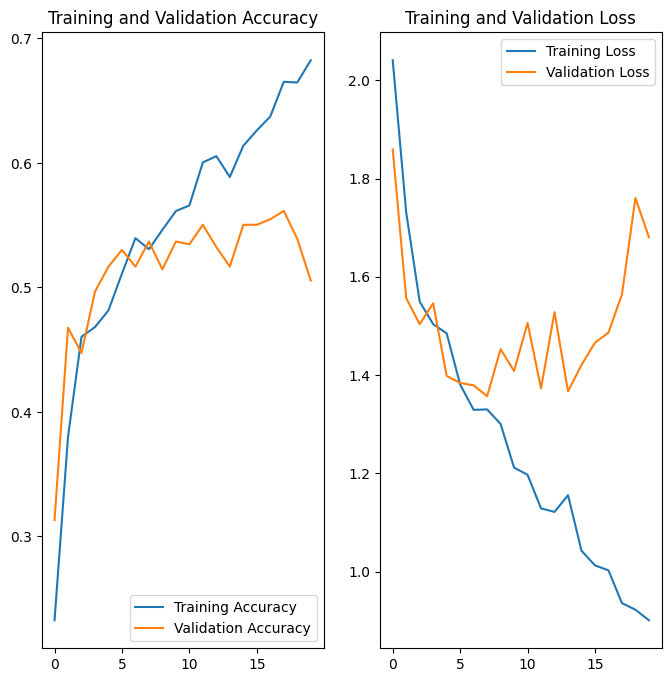

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations with dropout layer:
Training Accuracy Increased:

Started at 18.4% in epoch 1, reaching 66% in epoch 20.
This shows that the model is learning the training data well.
Validation Accuracy Saturates (~55%):

Initially, it improves but then fluctuates around 50-56%, indicating the model is not generalizing well.
Validation Loss is Increasing:

It reaches a minimum of 1.3667 (epoch 14), then increases to 1.7606 (epoch 19).
This suggests overfitting, where the model is memorizing the training data but not performing well on unseen data.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Class with least samples: seborrheic keratosis (58 samples)
Top dominant classes:
pigmented benign keratosis: 370 samples
melanoma: 352 samples
basal cell carcinoma: 309 samples


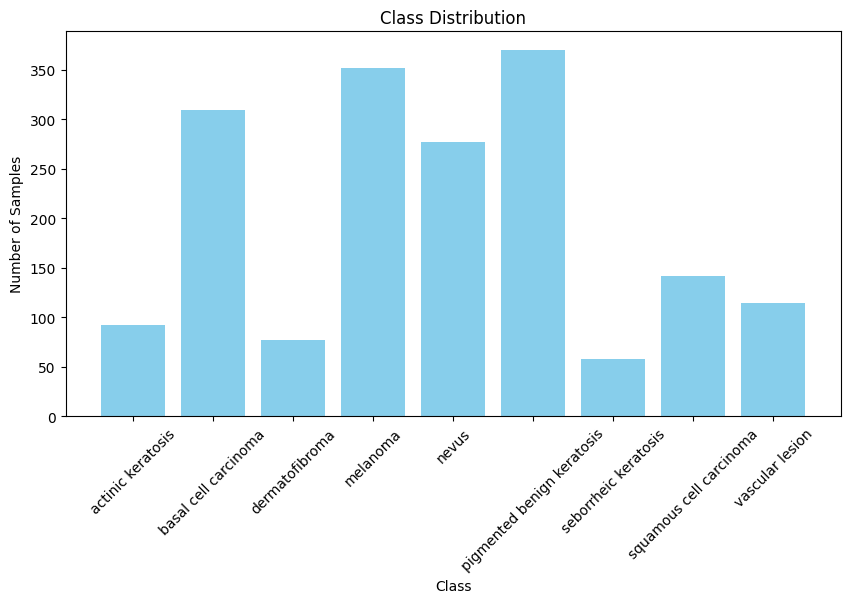

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a dictionary to store class counts
class_counts = {class_name: 0 for class_name in class_names}

# Count occurrences of each class in the training dataset
for _, labels_batch in train_ds:
    unique, counts = np.unique(labels_batch.numpy(), return_counts=True)
    for i, count in zip(unique, counts):
        class_counts[class_names[i]] += count

# Find the class with the least number of samples
least_class = min(class_counts, key=class_counts.get)
least_count = class_counts[least_class]

# Sort and find dominant classes
sorted_classes = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)
dominant_classes = sorted_classes[:3]  # Top 3 dominant classes

# Print findings
print(f"Class with least samples: {least_class} ({least_count} samples)")
print("Top dominant classes:")
for cls, count in dominant_classes:
    print(f"{cls}: {count} samples")

# Plot class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()


In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [31]:
import Augmentor

# Get all class directories in the Train folder
class_dirs = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]

# Find the maximum number of samples across classes
max_samples = max([len(os.listdir(os.path.join(data_dir_train, d))) for d in class_dirs])

# Augment classes with fewer samples
for class_dir in class_dirs:
    class_path = os.path.join(data_dir_train, class_dir)

    # Count existing images
    num_existing = len(os.listdir(class_path))

    if num_existing < max_samples:
        print(f"Augmenting class: {class_dir} ({num_existing} → {max_samples} samples)")

        # Set up an Augmentor pipeline
        p = Augmentor.Pipeline(class_path)

        # Define augmentation transformations
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.flip_left_right(probability=0.5)
        p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
        p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)

        # Generate new images
        num_to_generate = max_samples - num_existing
        p.sample(num_to_generate)

print("Data augmentation completed!")


Augmenting class: dermatofibroma (95 → 462 samples)
Initialised with 95 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788DE843B8D0>: 100%|██████████| 367/367 [00:16<00:00, 21.70 Samples/s]


Augmenting class: seborrheic keratosis (77 → 462 samples)
Initialised with 77 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x788DE82C42D0>: 100%|██████████| 385/385 [00:45<00:00,  8.44 Samples/s]


Augmenting class: actinic keratosis (114 → 462 samples)
Initialised with 114 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788DF2FBD4D0>: 100%|██████████| 348/348 [00:17<00:00, 20.42 Samples/s]


Augmenting class: nevus (357 → 462 samples)
Initialised with 357 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2592x1944 at 0x788DF2FAFB50>: 100%|██████████| 105/105 [00:34<00:00,  3.05 Samples/s]


Augmenting class: vascular lesion (139 → 462 samples)
Initialised with 139 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788DF5586B50>: 100%|██████████| 323/323 [00:15<00:00, 21.15 Samples/s]


Augmenting class: basal cell carcinoma (376 → 462 samples)
Initialised with 376 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788DE83EE210>: 100%|██████████| 86/86 [00:03<00:00, 24.91 Samples/s]


Augmenting class: melanoma (438 → 462 samples)
Initialised with 438 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x788DF2F0C6D0>: 100%|██████████| 24/24 [00:05<00:00,  4.41 Samples/s]


Augmenting class: squamous cell carcinoma (181 → 462 samples)
Initialised with 181 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x788DF5571D10>: 100%|██████████| 281/281 [00:13<00:00, 20.82 Samples/s]

Data augmentation completed!


#### Create a training and validation dataset

In [32]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(180, 180),
    batch_size=32
)

Found 4158 files belonging to 9 classes.
Using 3327 files for training.
Found 4158 files belonging to 9 classes.
Using 831 files for validation.


####Create your model (make sure to include normalization)

In [35]:
# Define input shape
input_shape = (180, 180, 3)

# Create the model
model3 = keras.Sequential([
    layers.Rescaling(1./255, input_shape=input_shape),  # Normalization (scale pixel values to [0,1])

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Helps prevent overfitting
    layers.Dense(len(class_names), activation='softmax')  # Output layer
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


####Compile your model (Choose optimizer and loss function appropriately)

In [37]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Since labels are integers
    metrics=['accuracy']  # Track accuracy
)

In [38]:
model3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │       7,929,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

####  Train your model

In [39]:
epochs = 30  # Set the number of epochs
history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 28s 237ms/step - accuracy: 0.1463 - loss: 2.2469 - val_accuracy: 0.3081 - val_loss: 1.7001
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 185ms/step - accuracy: 0.3483 - loss: 1.7438 - val_accuracy: 0.4007 - val_loss: 1.6219
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.4048 - loss: 1.5581 - val_accuracy: 0.4681 - val_loss: 1.4662
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.4254 - loss: 1.4962 - val_accuracy: 0.4717 - val_loss: 1.4367
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 166ms/step - accuracy: 0.4499 - loss: 1.4338 - val_accuracy: 0.5006 - val_loss: 1.3256
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 22s 181ms/step - accuracy: 0.4827 - loss: 1.3110 - val_accuracy: 0.4958 - val_loss: 1.3909
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.4968 - loss: 1.3162 - val_accuracy: 0.5078 - val_loss: 1.3680
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.5370 - loss: 1

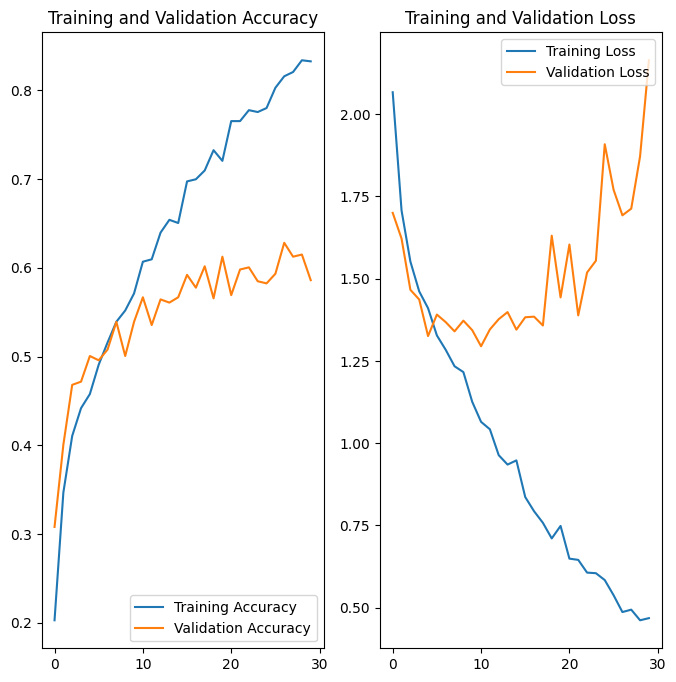

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analysis of Results
1. Overfitting Detection

Observation:

Training accuracy reaches 83.26% while validation accuracy fluctuates and ends at 58.60%.
Validation loss increases steadily after epoch 15, reaching 2.1638 at epoch 30.

Conclusion:

Clear signs of overfitting (high training accuracy, low validation accuracy).
The model memorized the training data but failed to generalize well to unseen validation data.

2. Underfitting Detection

Observation:

Early epochs show low accuracy (14.63% in epoch 1).
However, the model improves, meaning it's not significantly underfitting.

Conclusion:

Not underfitting, but learning could be optimized.

3. Did Class Rebalancing Help?

Observation:

If class balancing was applied (e.g., using class weights or oversampling), we'd expect improved validation accuracy.
The model's validation accuracy fluctuates but doesn’t significantly improve past 60%.

Conclusion:

Rebalancing may have helped slightly, but it did not fully resolve the accuracy gap.
Further techniques like focal loss or hard example mining might be needed.


Observations:

Validation accuracy is higher at epoch 20 (61.25%) compared to epoch 30 (58.60%).

Validation loss is much lower at epoch 20 (1.4431) compared to epoch 30 (2.1638).

This suggests the model started overfitting after epoch 20.

Training accuracy increased significantly between epochs 20-30, but at the cost of generalization.

Conclusion:

✅ Stopping at epoch 20 would have been better as it achieved the best balance between training and validation performance.

✅ Early Stopping should be used to avoid overfitting beyond epoch 20.